In [1]:
%%time
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

from Artha.nlp_extraction import run_pipeline, save_backup, load_backup, to_doc_dict
import Artha.data_process as dp
from Artha.neodb import Neo
import Artha.crypto_data as crypto
from tqdm import tqdm
import json
import numpy as np
np.set_printoptions(suppress=True)
from datetime import datetime, timedelta
from Artha.mentions import *
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import Artha.crypto_data as crypto

# coins database
neo = Neo("neo4j://localhost:7687", "neo4j", "part2")
neo.session.run('''CREATE CONSTRAINT twitter_username IF NOT EXISTS ON (n:Person)
                ASSERT n.username IS UNIQUE''')
neo.session.run('''CREATE CONSTRAINT coin_name IF NOT EXISTS ON (n:Coin)
                ASSERT n.ticker IS UNIQUE''')


CPU times: user 2.21 s, sys: 378 ms, total: 2.59 s
Wall time: 3.86 s


In [2]:
follow_weight = .5
print(len(neo.get_nodes()), len(neo.get_relations()))
# without mentions 711 6958

149 291


In [3]:
neo.clear_nodes()

In [4]:
%%time
# add follows between only people I follow, can change by getting rid of second 2 last line for anyone a person follows

# all_people = [i[1:-4] for i in os.listdir("../data/follows/")]
# checkra_people = [c[3] for c in dp.load_following("checkra_") ]


selected_people = ["BTC_JackSparrow", "Nostranomist", "CryptoKaleo", "nebraskangooner", "Rager", "SavageBTC", "TraderMayne", "IamCryptoWolf", "CryptoNewton"]
selected_nodes = [c for c in dp.load_following("checkra_") if c[3] in selected_people]

selected_follows = dp.follow_edges(selected_people, follow_weight)

CPU times: user 8.64 ms, sys: 2.54 ms, total: 11.2 ms
Wall time: 14 ms


In [5]:
%%time
# print(len(follows))
neo.clear_nodes()

neo.load_follow_nodes(selected_nodes)
neo.load_follow_nodes(selected_follows)
neo.load_follow_relations(selected_follows)

print(len(neo.get_nodes()), len(neo.get_relations()))


8 22
CPU times: user 8.97 ms, sys: 2.88 ms, total: 11.8 ms
Wall time: 90.5 ms


In [6]:
%%time
# load all tweets
# all_tweets = []
# for ind, username in tqdm(enumerate(selected_people)):
#     cur_tweets = dp.load_tweets(username, location = "../data/tweets1/u")
#     all_tweets.extend([tweet for tweet in dp.clean_tweets(cur_tweets, username)])

# print("\n", len(all_tweets))
# #process all tweets at once
# docs = run_pipeline(all_tweets)
# 

docs = load_backup()
doc_dict = to_doc_dict(docs)

loaded
100%|██████████| 19935/19935 [00:00<00:00, 151976.10it/s]CPU times: user 7.37 s, sys: 227 ms, total: 7.6 s
Wall time: 7.66 s



In [40]:
%%time
# code for multiple graphs over time
day_scores = {}
start_date, window_count = "01/01/2021 00:00:00", 60

dates = [from_datetime(to_datetime(start_date)+timedelta(days=i)) for i in range(window_count)]

for date in tqdm(dates):
    all_mentions = [edge for person in selected_people 
                    for edge in get_mention_edges(
                                      doc_dict[person], person,
                                      follow_weight = follow_weight,
                                      win_start_date = date)]
    neo.clear_nodes("Coin")
    neo.load_mentions(all_mentions)
    day_scores[date] = neo.pagerank_scores()

all_ticks = list(set([tick[0] for day in dates for tick in day_scores[day]]))

tick_dict = {tick: np.zeros(window_count) for tick in all_ticks}

for ind, day in enumerate(day_scores.keys()):
    for score in day_scores[day]:
        tick_dict[score[0]][ind] = score[1]

pdrank = pd.DataFrame(tick_dict, index = pd.to_datetime(dates))


100%|██████████| 60/60 [01:02<00:00,  1.04s/it]CPU times: user 47.2 s, sys: 1.1 s, total: 48.3 s
Wall time: 1min 2s



In [135]:
%%time
ticker = "DOGE"
if ticker == "BTC":
    asset = ticker+"USDT"
else:
    asset = ticker+"BTC"

interval = '2h'
newest, oldest = pdrank[ticker].index[-1].to_pydatetime().timestamp() * 1000, pdrank[ticker].index[0].to_pydatetime().timestamp() * 1000, 
klines = crypto.get_klines(asset, time, oldest, newest)
df = crypto.get_klines_df(klines)

CPU times: user 33.2 ms, sys: 21.5 ms, total: 54.6 ms
Wall time: 1.33 s


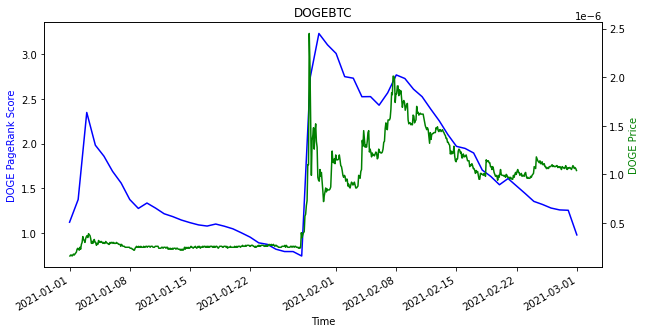

In [137]:
plt.rcParams['figure.figsize'] = [10, 5]
ts = df["Close"].astype(float) #.pct_change()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(pdrank[ticker].index, pdrank[ticker], color='b')

ax2.plot(ts.index, ts, color='g')

ax1.set_xlabel('Time')
ax1.set_ylabel(ticker+" PageRank Score", color='b')
ax2.set_ylabel(ticker +" Price", color='g')

plt.title(asset)
plt.gcf().autofmt_xdate()